In [33]:
import functions_model_analysis as f
import numpy as np
import pandas as pd
import sys 
 
sys.path.insert(0, '../AWS_Scripts')
from functions_training_pipeline import Model

### Load models

In [2]:
LinReg = f.load_object('LinearRegression')
#LinReg_noXY = f.load_object('LinearRegression_NoXY')
#RigdeReg = f.load_object('RidgeRegression')
LassoReg = f.load_object('LassoRegression')
#ElasticNetReg = f.load_object('ElasticNetRegression')
RandomForest = f.load_object('RandomForest')
GradientBoosting = f.load_object('XGBoost')

In [3]:
model_list = [LinReg, LinReg_noXY, RigdeReg, LassoReg, ElasticNetReg, RandomForest, GradientBoosting]

In [3]:
model_list = [LinReg, LassoReg, RandomForest, GradientBoosting]

In [5]:
RigdeReg.cv_model_list

[Ridge(alpha=50),
 Ridge(alpha=50),
 Ridge(alpha=15),
 Ridge(alpha=50),
 Ridge(alpha=50)]

In [5]:
LassoReg.cv_model_list

[Lasso(alpha=0.01),
 Lasso(alpha=0.01),
 Lasso(alpha=0.01),
 Lasso(alpha=0.01),
 Lasso(alpha=0.01)]

In [21]:
ElasticNetReg.cv_model_list

[ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1),
 ElasticNet(alpha=0.5, l1_ratio=0.1)]

### Investigate Intercept & Coefs of Lasso

In [38]:

intercept = 0
coefs = []
for m in LassoReg.cv_model_list:
    intercept += m.intercept_
    coefs.append(m.coef_)

# take mean of coefs
coefs_mean = np.array(coefs)
coefs_mean = np.mean(coefs_mean, axis=0)
# mean intercept
intercept = intercept/len(LassoReg.cv_model_list)

print("mean intercept: ", intercept)
print(coefs_mean)
print("[ ","mean_9, ", "mw_value_yesterday, ", "mw_value_7_day_average", " ]")


mean intercept:  0.2803063255658139
[0.         0.         0.         0.         0.11769664 0.
 0.05847044 0.01549089 0.         0.         0.         0.
 0.        ]
[  mean_9,  mw_value_yesterday,  mw_value_7_day_average  ]


In [32]:
f4 = []
f6 = []
f7 =[]
for a in coefs:
    f4.append(a[4])
    f6.append(a[6])
    f7.append(a[7])

# print std of f4, f6, f7
print(np.std(f4))
print(np.std(f6))
print(np.std(f7))

0.014185985880098765
0.008430807640380142
0.011292043738200913


### Feature importance

LinearRegression


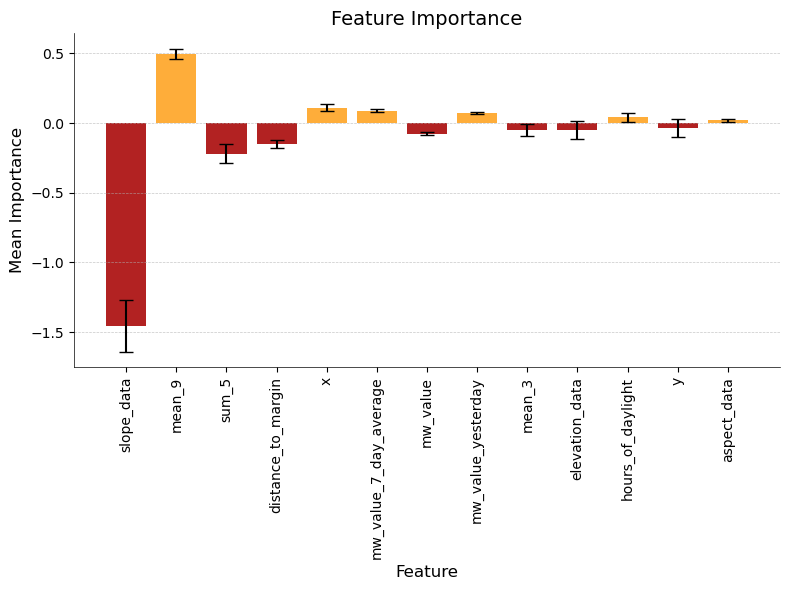

LassoRegression


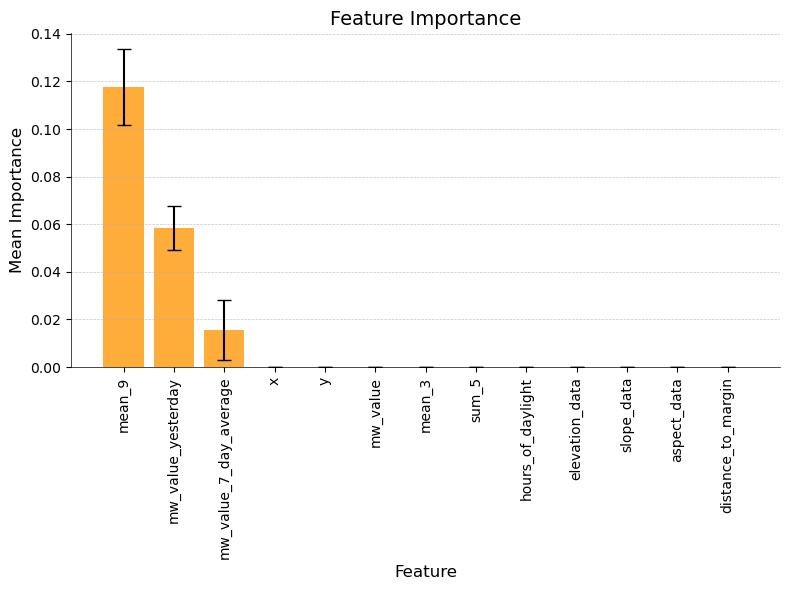

RandomForest


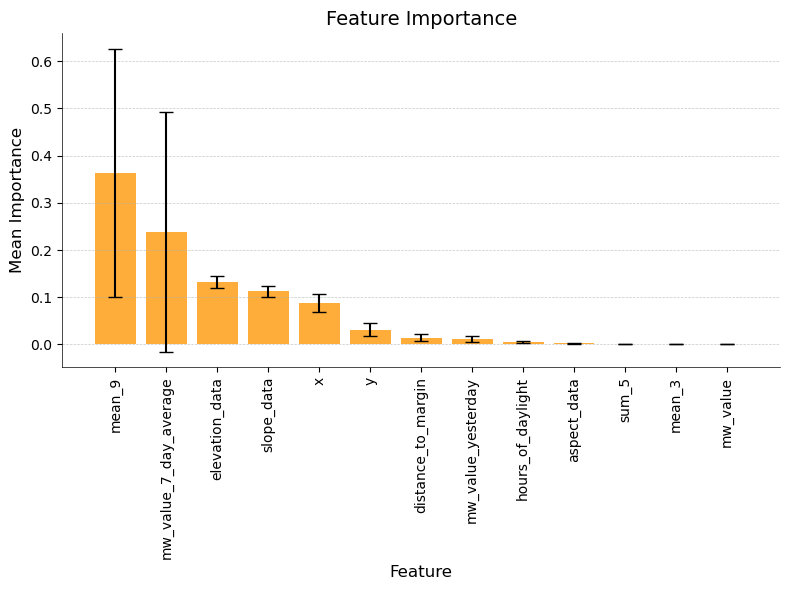

XGBoost


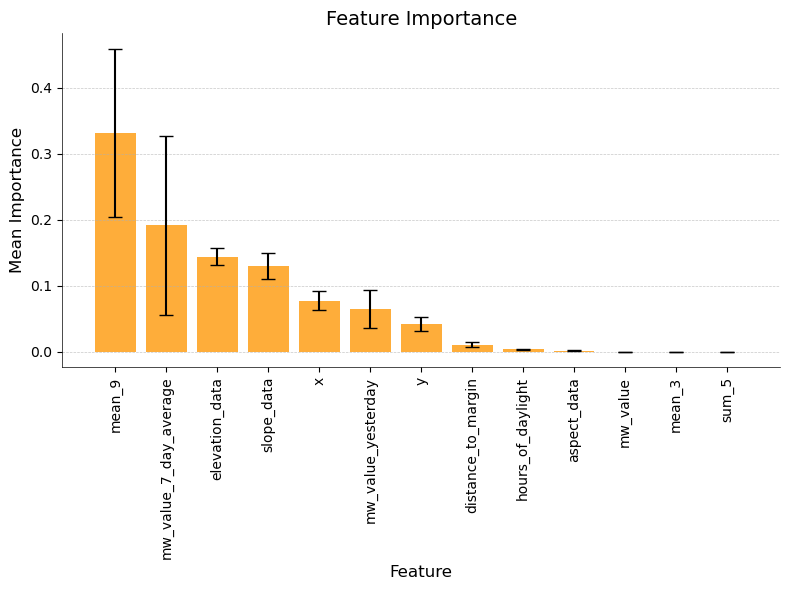

In [4]:
#f.plot_feature_importance(LinReg)

for model in model_list:
    print(model.name)
    f.plot_feature_importance(model)

In [32]:
feature_importance_df = []
for model in model_list:
    for mod in model.cv_model_list:
        feature_importance = f.feature_importance_dict(mod, model.columns)
        if len(feature_importance_df) == 0:
                feature_importance_df = pd.DataFrame(feature_importance, index=[0])
        else:
            feature_importance_df = pd.concat(
                [feature_importance_df, pd.DataFrame([feature_importance])],
                ignore_index=True,
            )

    # sort features by mean importance in descending order by absolute value
    mean_importances = feature_importance_df.mean()
    print(model.name)
    print(mean_importances)
    print()

LinearRegression
x                         0.110506
y                        -0.035898
mw_value                 -0.077124
mean_3                   -0.050731
mean_9                    0.497473
sum_5                    -0.220134
mw_value_yesterday        0.070658
mw_value_7_day_average    0.089185
hours_of_daylight         0.040591
elevation_data           -0.049884
slope_data               -1.455676
aspect_data               0.020444
distance_to_margin       -0.152848
dtype: float64

LassoRegression
x                         0.055253
y                        -0.017949
mw_value                 -0.038562
mean_3                   -0.025366
mean_9                    0.307585
sum_5                    -0.110067
mw_value_yesterday        0.064564
mw_value_7_day_average    0.052338
hours_of_daylight         0.020295
elevation_data           -0.024942
slope_data               -0.727838
aspect_data               0.010222
distance_to_margin       -0.076424
dtype: float64

RandomForest
x           

In [21]:
DT = f.load_object('DecisionTree')

In [22]:
DT.columns

Index(['x', 'y', 'mw_value', 'mean_3', 'mean_9', 'sum_5', 'mw_value_yesterday',
       'mw_value_7_day_average', 'hours_of_daylight', 'elevation_data',
       'slope_data', 'aspect_data', 'distance_to_margin'],
      dtype='object')

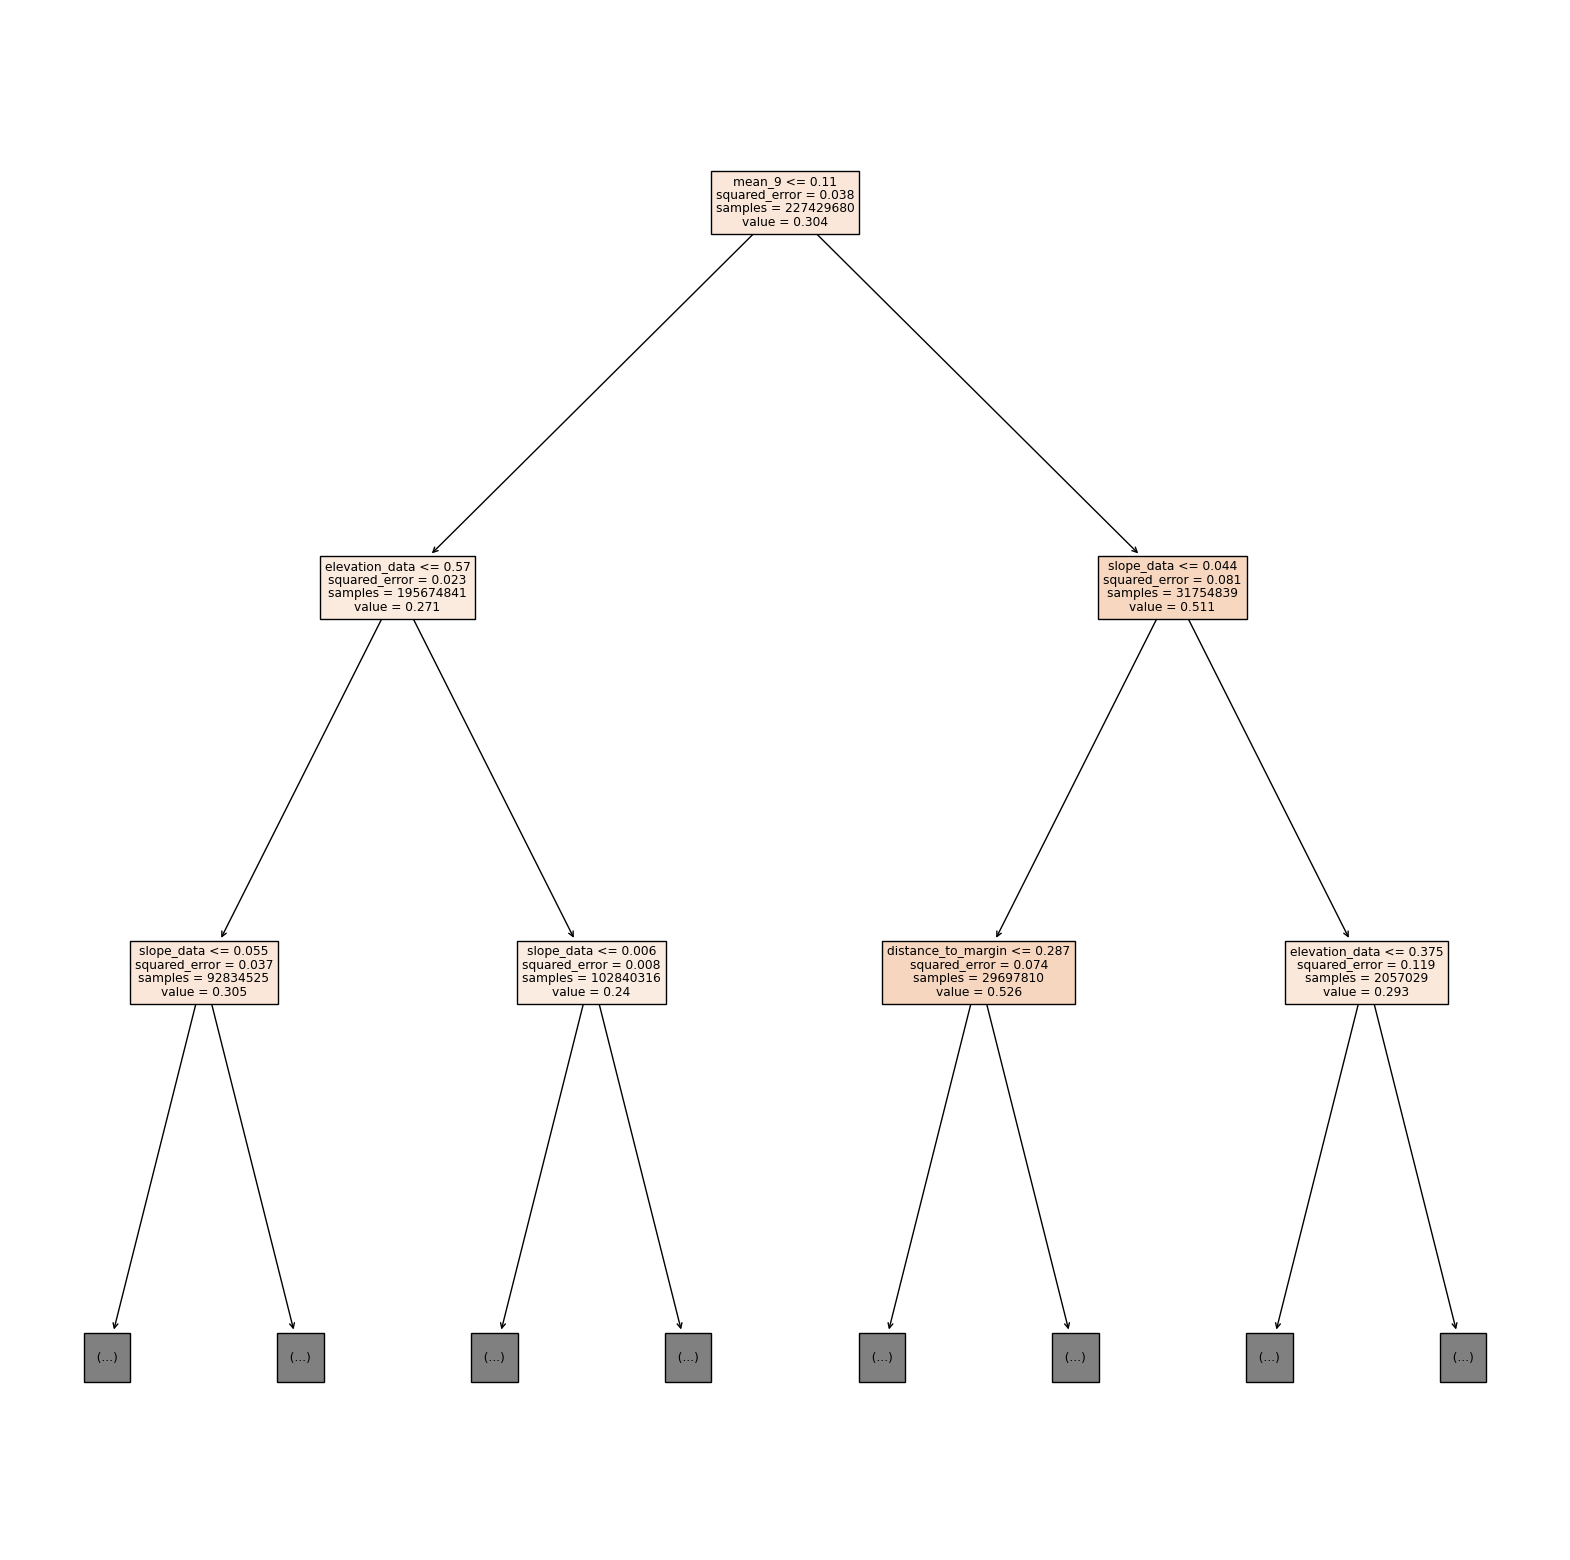

In [29]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot the decision tree
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(DT.final_model, max_depth=2,  feature_names=DT.columns, class_names=True, filled=True, ax=ax)

# Show the plot
plt.show()

### Model performance

In [4]:
table = f.model_comparison_table(model_list).reset_index()

In [5]:
table

,Model,Set,RMSE,RMSE_std,R2,R2_std
0,LinearRegression,Train,0.182667,0.007470,0.118834,0.008399
1,LinearRegression,Test,0.184476,0.031713,0.048278,0.194516
2,LinearRegression_NoXY,Train,0.183551,0.007386,0.110161,0.008204
3,LinearRegression_NoXY,Test,0.183465,0.024423,0.060173,0.129444
4,RidgeRegression,Train,0.182664,0.007468,0.118860,0.008399
5,RidgeRegression,Test,0.184469,0.031698,0.048343,0.194484
6,LassoRegression,Train,0.180727,0.006904,0.137103,0.015288
7,LassoRegression,Test,0.179078,0.016030,0.099684,0.086524
8,ElasticNetRegression,Train,0.183219,0.007700,0.113534,0.013190
9,ElasticNetRegression,Test,0.185035,0.028033,0.035457,0.208491


In [6]:
table[table['Set']=='Test']

,Model,Set,RMSE,RMSE_std,R2,R2_std
1,LinearRegression,Test,0.184476,0.031713,0.048278,0.194516
3,LinearRegression_NoXY,Test,0.183465,0.024423,0.060173,0.129444
5,RidgeRegression,Test,0.184469,0.031698,0.048343,0.194484
7,LassoRegression,Test,0.179078,0.016030,0.099684,0.086524
9,ElasticNetRegression,Test,0.185035,0.028033,0.035457,0.208491
11,RandomForest,Test,0.197773,0.030502,-0.101216,0.246953
13,XGBoost,Test,0.188516,0.032070,-0.012913,0.300837


## old models

LinearRegression


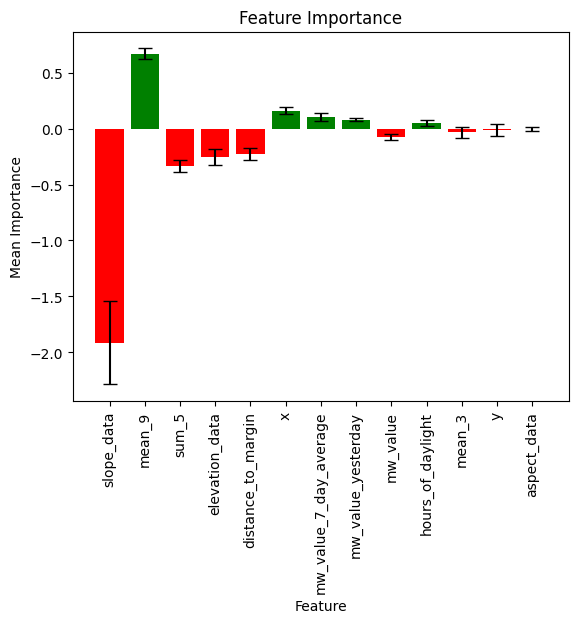

LinearRegression


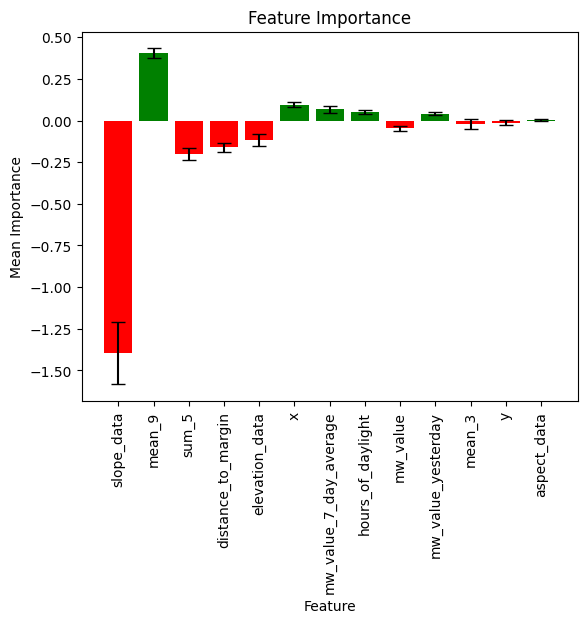

RidgeRegression


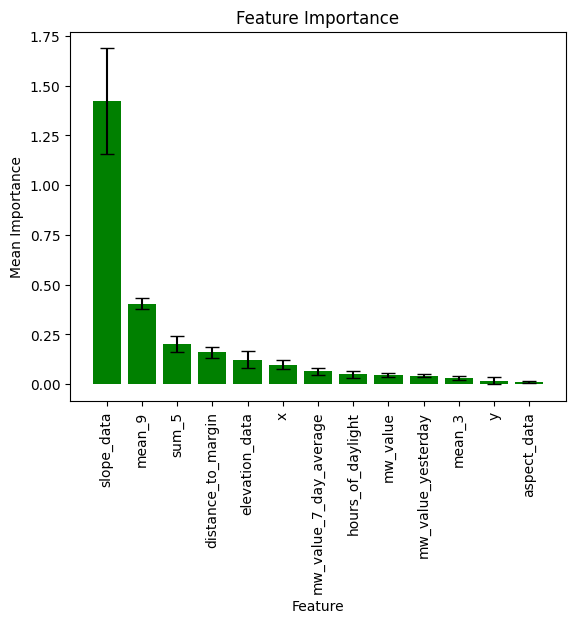

RidgeRegression_WithoutLog


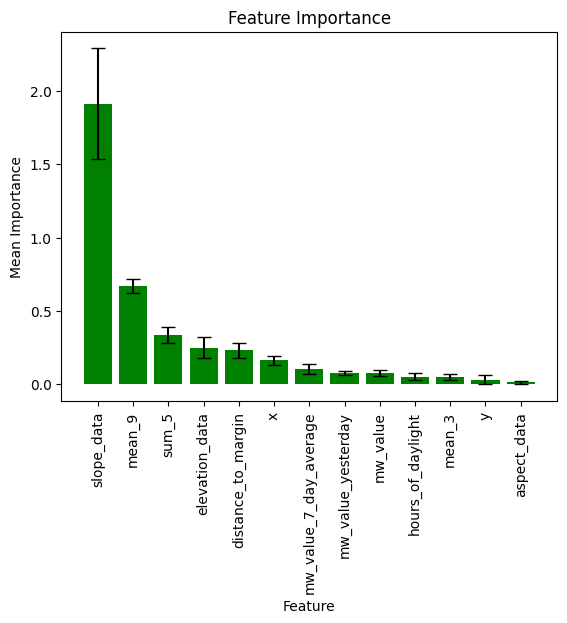

LassoRegression


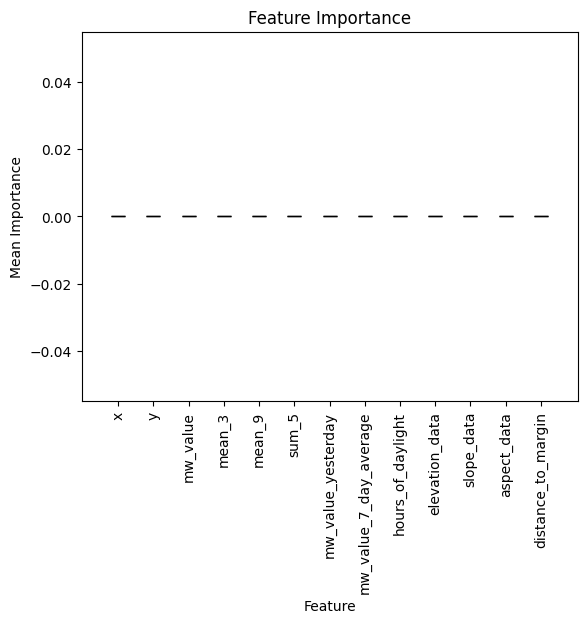

ElasticNetRegression


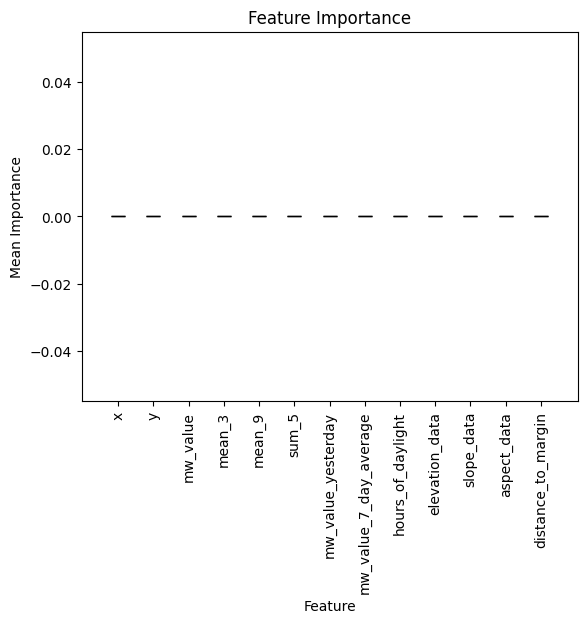

In [8]:
for model in [LinReg_noLog, LinReg, RigdeReg, RidgeReg_noLog, LassoReg, ElasticNetReg]:
    print(model.name)
    f.plot_feature_importance(model)

In [23]:
LinReg_noLog = f.load_object('LinearRegression_WithoutLog')
LinReg = f.load_object('LinearRegression')

RigdeReg = f.load_object('RidgeRegression')
RidgeReg_noLog = f.load_object('RidgeRegression_WithoutLog')

LassoReg = f.load_object('LassoRegression')
ElasticNetReg = f.load_object('ElasticNetRegression')

In [17]:
for model in RigdeReg.cv_model_list:
    print(model.get_params())

{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
{'alpha': 20, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [18]:
for model in LassoReg.cv_model_list:
    print(model.get_params())

{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [4]:
LinReg_noXY = f.load_object('LinearRegression_NoXY')

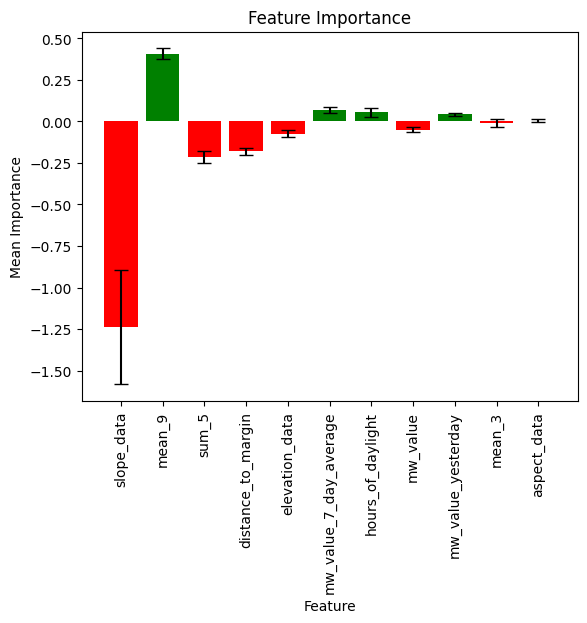

In [5]:
f.plot_feature_importance(LinReg_noXY)

In [13]:
f.model_comparison_table([LinReg_noXY, LinReg])

RMSE  RMSE_std        R2    R2_std
Model                 Set                                          
LinearRegression_NoXY Train  0.033267  0.001241  0.125254  0.009330
                      Test   0.035891  0.008988  0.044028  0.219795
LinearRegression      Train  0.033137  0.001464  0.128257  0.007396
                      Test   0.036065  0.008292  0.027555  0.130037

In [ ]:
f.model_comparison_table([LinReg_noXY, LinReg])

In [22]:
RidgeReg.get_results()

NameError: name 'RidgeReg' is not defined

In [7]:
# hyperparameter analysis

In [10]:
# get hyperparameters of all 7 models
LassoReg.cv_model_list

[Lasso(alpha=0.5),
 Lasso(alpha=0.5),
 Lasso(alpha=0.5),
 Lasso(alpha=0.5),
 Lasso(alpha=0.5)]

In [11]:
for i in range(5):
    print(LassoReg.cv_model_list[i].get_params())

{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [12]:
for i in range(5):
    print(ElasticNetReg.cv_model_list[i].get_params())

{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
{'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selectio